Specification:
<center>"we would like to predict the number of order days in the month for each user, and
we want to be able to perform this prediction at every point of the month."</center>

- Business Problem = understand the order days for each user in a month
- Important = be able to generate predictions in all part of month window

## Used Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.arima.model import ARIMA


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

## Load the Data

In [3]:
df_train = pd.read_parquet('./data/silver/historical_orders.parquet')
df_reality = pd.read_parquet('./data/silver/august_with_missing_order_days.parquet')
df_forecast = pd.read_parquet('./data/silver/august_total_sales.parquet')


## Data Description

In [4]:
print(df_train.shape)
print(df_train.head())

(8596877, 3)
          account_id  order_date  transaction_amount
0  BR_09607801000194  2021-08-28             11011.2
1  BR_09607801000194  2021-08-28             13764.0
2  BR_09607801000194  2021-08-28             11011.2
3  BR_09607801000194  2021-08-28             11011.2
4  BR_09607801000194  2021-08-28             13764.0


In [5]:
print(min(df_train['order_date']))
print(max(df_train['order_date']))

2021-01-02
2022-07-31


In [6]:
df_reality.head()

,account_id,order_date,transaction_amount
0,BR_09532176632,2022-08-03,11.16
1,BR_09532176632,2022-08-03,32.52
2,BR_09532176632,2022-08-03,24.90
3,BR_09532176632,2022-08-03,28.50
4,BR_09532176632,2022-08-03,11.16


In [7]:
df_forecast.head()

,account_id,total_transaction_amount_august
0,BR_00000343803,309.99
1,BR_00001415930,874.98
2,BR_00001760106,11976.70
3,BR_00002485176,511.48
4,BR_00002536340,7081.14


Dataset for trainning (df_train):

The name of columns show their meaning (account_id, order_date, transaction_amount)

## Data Cleaning

Df_train data does not includes NaN value.

In [8]:
df_train.isna().sum()

account_id            0
order_date            0
transaction_amount    0
dtype: int64

-----

## Target Definition

Target = Number of orders in *distinct* days

The main idea is an adjusting of the dataset in order to create a feature that denotes the number of orders like coutdown pattern.
Them, the model will answer as requested:

<center> "we would like our model to predict before Jan' 4th that we're expecting 2 days of orders
(prediction = 2), and after Jan' 4th (and before Jan' 25th), we would like the model to predict that there is
1 day of orders left (prediction = 1)."*" </center>

First of all, I agreggated the dataset by account_id and order_date in order to indentify order volume.

In [9]:
df_train['order_date'] = pd.to_datetime(df_train['order_date'])

df_daily = (df_train.groupby(['account_id', 'order_date'])
              .size()
              .reset_index(name='num_orders'))

df_daily['has_order'] = (df_daily['num_orders'] > 0).astype(int)

At next, the idea is the creation of target who represents the maximum value of orders and they are decreasing over month.

To do this I defined a sum of num_orders per month and year.
Then, I defined the maximum value of num_orders per day in order to define a cumulative progression.

In [10]:
#I'm creating a camp target creates the sum of orders in same month and year df_daily
df_daily['order_month'] = df_daily['order_date'].dt.to_period('M')

#I'm doing an inverse cumsum
df_daily['acumulado'] = df_daily.groupby(['account_id', 'order_month'])['num_orders'].transform('cumsum')
df_daily['max'] = df_daily.groupby(['account_id', 'order_month'])['num_orders'].transform('sum')

#I'm subtracting the max of first  with acumulado of second and so on
df_daily['target'] = df_daily['max'] - df_daily['acumulado'].shift(1)

df_daily['target'] = np.where(df_daily['target'] < 0, df_daily['max'], df_daily['target'])
df_daily['target'] = np.where(df_daily['target'].isna(), df_daily['max'], df_daily['target'])

df_daily = df_daily.drop(columns=['num_orders', 'has_order', 'acumulado', 'max', 'order_month'])

In [11]:
df_daily.head(10)

,account_id,order_date,target
0,BR_00000343803,2021-01-07,7.0
1,BR_00000343803,2021-01-14,5.0
2,BR_00000343803,2021-01-21,4.0
3,BR_00000343803,2021-01-30,2.0
4,BR_00000343803,2021-02-11,4.0
5,BR_00000343803,2021-02-18,3.0
6,BR_00000343803,2021-03-04,2.0
7,BR_00000343803,2021-03-20,2.0
8,BR_00000343803,2021-03-25,1.0
9,BR_00000343803,2021-04-15,4.0


In [12]:
df_daily.sort_values(by=['account_id', 'order_date'], inplace=True)
df_daily.head(10)

,account_id,order_date,target
0,BR_00000343803,2021-01-07,7.0
1,BR_00000343803,2021-01-14,5.0
2,BR_00000343803,2021-01-21,4.0
3,BR_00000343803,2021-01-30,2.0
4,BR_00000343803,2021-02-11,4.0
5,BR_00000343803,2021-02-18,3.0
6,BR_00000343803,2021-03-04,2.0
7,BR_00000343803,2021-03-20,2.0
8,BR_00000343803,2021-03-25,1.0
9,BR_00000343803,2021-04-15,4.0


In [13]:
import pandas as pd

def calculate_mean_target_by_day_range(
    df: pd.DataFrame,
    day_range: tuple,
    target_col: str = 'target',
    new_col_name: str = None
) -> pd.DataFrame:
    """
    Calculates the mean target for a specific day range and merges it back into the original DataFrame.

    Args:
        df: Input DataFrame with 'order_date' and 'target' columns.
        day_range: Tuple of (min_day, max_day) to filter dates.
        target_col: Name of the target column.
        new_col_name: Name for the new mean target column.

    Returns:
        DataFrame with the new mean target column merged.
    """
    # Ensure 'order_date' is datetime and extract date parts
    df = df.copy()
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['year'] = df['order_date'].dt.year
    df['month'] = df['order_date'].dt.month
    df['day'] = df['order_date'].dt.day

    # Filter rows within the day range
    min_day, max_day = day_range
    filtered = df[(df['day'] >= min_day) & (df['day'] <= max_day)]

    # Calculate mean target per account_id, year, and month
    mean_target = (
        filtered
        .groupby(['account_id', 'year', 'month'])[target_col]
        .mean()
        .reset_index()
    )

    # Set default column name if not provided
    if not new_col_name:
        new_col_name = f'mean_target_days_{min_day}_to_{max_day}'

    mean_target.rename(columns={target_col: new_col_name}, inplace=True)

    # Merge back to original DataFrame and drop temp columns
    df = pd.merge(
        df,
        mean_target,
        on=['account_id', 'year', 'month'],
        how='left'
    )
    #df.drop(['year', 'month', 'day'], axis=1, inplace=True)

    return df

In [14]:
# Example usage
df = df_daily.copy()

day_ranges = [
    ((1, 1), 'mean_target_first_day'),
    ((2, 3), 'mean_target_days_2_to_3'),
    ((4, 5), 'mean_target_days_4_to_5'),
    ((6, 7), 'mean_target_days_6_to_7'),
    ((8, 9), 'mean_target_days_8_to_9'),
    ((10, 11), 'mean_target_days_10_to_11'),
    ((12, 13), 'mean_target_days_12_to_13'),
    ((14, 15), 'mean_target_days_14_to_15'),
    ((16, 17), 'mean_target_days_16_to_17'),
    ((18, 19), 'mean_target_days_18_to_19'),
    ((20, 21), 'mean_target_days_20_to_21'),
    ((22, 23), 'mean_target_days_22_to_23'),
    ((24, 25), 'mean_target_days_24_to_25'),
    ((26, 27), 'mean_target_days_26_to_27'),
    ((28, 29), 'mean_target_days_28_to_29'),
    ((30, 31), 'mean_target_days_30_to_31')
]

df = df_daily.copy()
for (min_day, max_day), col_name in day_ranges:
    df = calculate_mean_target_by_day_range(
        df,
        day_range=(min_day, max_day),
        new_col_name=col_name
    )

print(df)

             account_id order_date  target  year  month  day  \
0        BR_00000343803 2021-01-07     7.0  2021      1    7   
1        BR_00000343803 2021-01-14     5.0  2021      1   14   
2        BR_00000343803 2021-01-21     4.0  2021      1   21   
3        BR_00000343803 2021-01-30     2.0  2021      1   30   
4        BR_00000343803 2021-02-11     4.0  2021      2   11   
...                 ...        ...     ...   ...    ...  ...   
1428379  BR_99980878134 2021-05-29     4.0  2021      5   29   
1428380  BR_99980878134 2021-06-07    10.0  2021      6    7   
1428381  BR_99980878134 2021-06-10     8.0  2021      6   10   
1428382  BR_99980878134 2021-06-12     6.0  2021      6   12   
1428383  BR_99980878134 2021-06-17     5.0  2021      6   17   

         mean_target_first_day  mean_target_days_2_to_3  \
0                          NaN                      NaN   
1                          NaN                      NaN   
2                          NaN                      Na

In [15]:
df['order_date'] = pd.to_datetime(df['order_date'])
df = df.sort_values(by=['account_id', 'order_date'])

# I'm calculate the 30-day moving average for each 'account_id'
df['media_30_dias'] = (
    df.groupby('account_id')
    .apply(lambda x: x.set_index('order_date')['target'].rolling('30D').mean())
    .reset_index(drop=True)
)

print(df)

/var/folders/b3/vknwq1q17vlg9qtvyb0f5c_c0000gn/T/ipykernel_29200/3293418050.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.set_index('order_date')['target'].rolling('30D').mean())


             account_id order_date  target  year  month  day  \
0        BR_00000343803 2021-01-07     7.0  2021      1    7   
1        BR_00000343803 2021-01-14     5.0  2021      1   14   
2        BR_00000343803 2021-01-21     4.0  2021      1   21   
3        BR_00000343803 2021-01-30     2.0  2021      1   30   
4        BR_00000343803 2021-02-11     4.0  2021      2   11   
...                 ...        ...     ...   ...    ...  ...   
1428379  BR_99980878134 2021-05-29     4.0  2021      5   29   
1428380  BR_99980878134 2021-06-07    10.0  2021      6    7   
1428381  BR_99980878134 2021-06-10     8.0  2021      6   10   
1428382  BR_99980878134 2021-06-12     6.0  2021      6   12   
1428383  BR_99980878134 2021-06-17     5.0  2021      6   17   

         mean_target_first_day  mean_target_days_2_to_3  \
0                          NaN                      NaN   
1                          NaN                      NaN   
2                          NaN                      Na

In [16]:
# I'm creating lag features (previous target values)
df['prev_target'] = df.groupby('account_id')['target'].shift(1)
df['prev_target'] = df['prev_target'].fillna(0)

---

## Data Exploration

Lets start with basics of visualization that is understanding data.

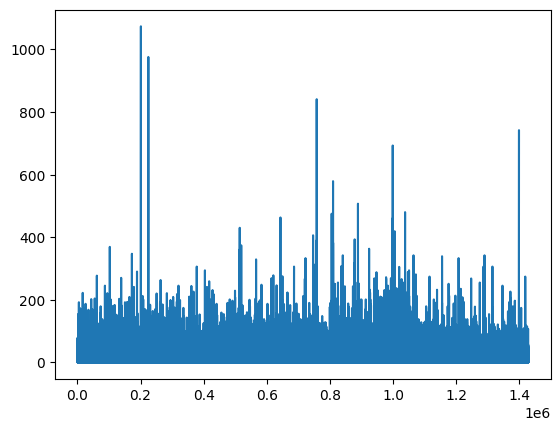

In [17]:
plt.plot(df.target)

/var/folders/b3/vknwq1q17vlg9qtvyb0f5c_c0000gn/T/ipykernel_29200/183030011.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.resample('M').sum()['target'].plot()


<Axes: xlabel='order_date'>

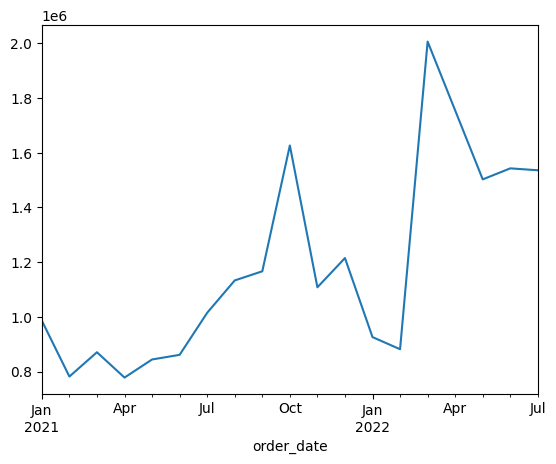

In [18]:
# I'm checkout temporal tendecies over months
df.set_index('order_date', inplace=True)
df.resample('M').sum()['target'].plot()


---

## Data Preparation

In [19]:
df['mean_target_first_day'] = df['mean_target_first_day'].fillna(0)
df['mean_target_days_2_to_3'] = df['mean_target_days_2_to_3'].fillna(0)
df['mean_target_days_4_to_5'] = df['mean_target_days_4_to_5'].fillna(0)
df['mean_target_days_6_to_7'] = df['mean_target_days_6_to_7'].fillna(0)
df['mean_target_days_8_to_9'] = df['mean_target_days_8_to_9'].fillna(0)
df['mean_target_days_10_to_11'] = df['mean_target_days_10_to_11'].fillna(0)
df['mean_target_days_12_to_13'] = df['mean_target_days_12_to_13'].fillna(0)
df['mean_target_days_14_to_15'] = df['mean_target_days_14_to_15'].fillna(0)
df['mean_target_days_16_to_17'] = df['mean_target_days_16_to_17'].fillna(0)
df['mean_target_days_18_to_19'] = df['mean_target_days_18_to_19'].fillna(0)
df['mean_target_days_20_to_21'] = df['mean_target_days_20_to_21'].fillna(0)
df['mean_target_days_22_to_23'] = df['mean_target_days_22_to_23'].fillna(0)
df['mean_target_days_24_to_25'] = df['mean_target_days_24_to_25'].fillna(0)
df['mean_target_days_26_to_27'] = df['mean_target_days_26_to_27'].fillna(0)
df['mean_target_days_28_to_29'] = df['mean_target_days_28_to_29'].fillna(0)
df['mean_target_days_30_to_31'] = df['mean_target_days_30_to_31'].fillna(0)

df['prev_target'] = df['prev_target'].fillna(0)
df['media_30_dias'] = df['media_30_dias'].fillna(0)

In [20]:
df

,account_id,target,year,month,day,mean_target_first_day,mean_target_days_2_to_3,mean_target_days_4_to_5,mean_target_days_6_to_7,mean_target_days_8_to_9,...,mean_target_days_16_to_17,mean_target_days_18_to_19,mean_target_days_20_to_21,mean_target_days_22_to_23,mean_target_days_24_to_25,mean_target_days_26_to_27,mean_target_days_28_to_29,mean_target_days_30_to_31,media_30_dias,prev_target
order_date,,,,,,,,,,,,,,,,,,,,,
2021-01-07,BR_00000343803,7.0,2021,1,7,0.0,0.0,0.0,7.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0,7.000000,0.0
2021-01-14,BR_00000343803,5.0,2021,1,14,0.0,0.0,0.0,7.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0,6.000000,7.0
2021-01-21,BR_00000343803,4.0,2021,1,21,0.0,0.0,0.0,7.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0,5.333333,5.0
2021-01-30,BR_00000343803,2.0,2021,1,30,0.0,0.0,0.0,7.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0,4.500000,4.0
2021-02-11,BR_00000343803,4.0,2021,2,11,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.750000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-29,BR_99980878134,4.0,2021,5,29,0.0,0.0,0.0,0.0,0.0,...,0.0,13.0,0.0,0.0,7.0,0.0,4.0,0.0,8.000000,7.0
2021-06-07,BR_99980878134,10.0,2021,6,7,0.0,0.0,0.0,10.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.500000,4.0
2021-06-10,BR_99980878134,8.0,2021,6,10,0.0,0.0,0.0,10.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.400000,10.0


In [21]:
df.columns

Index(['account_id', 'target', 'year', 'month', 'day', 'mean_target_first_day',
       'mean_target_days_2_to_3', 'mean_target_days_4_to_5',
       'mean_target_days_6_to_7', 'mean_target_days_8_to_9',
       'mean_target_days_10_to_11', 'mean_target_days_12_to_13',
       'mean_target_days_14_to_15', 'mean_target_days_16_to_17',
       'mean_target_days_18_to_19', 'mean_target_days_20_to_21',
       'mean_target_days_22_to_23', 'mean_target_days_24_to_25',
       'mean_target_days_26_to_27', 'mean_target_days_28_to_29',
       'mean_target_days_30_to_31', 'media_30_dias', 'prev_target'],
      dtype='object')

In [22]:
df.shape

(1428384, 23)

In [23]:
df.account_id.nunique()

47899

In [24]:
X = df.drop(['target', 'account_id'], axis=1)
y = df['target']

In [25]:
# I'm spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

---

## Model Definition

At first moment, I don't have a strong idea which model apply, but I have a feeling based on my background that Random Forest or XGBoost could be useful methods for these scenario.

### Random Forest

In [26]:
# I'm initializing and trainning Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

print("Random Forest Performance:")
print(f"MAE: {mean_absolute_error(y_test, rf_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, rf_pred)):.2f}")

Random Forest Performance:
MAE: 0.41
RMSE: 2.64


### XGBoost

In [27]:
# I'm initializing and trainning XGBoost
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)

xgb_pred = xgb.predict(X_test)

print("\nXGBoost Performance:")
print(f"MAE: {mean_absolute_error(y_test, xgb_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, xgb_pred)):.2f}")


XGBoost Performance:
MAE: 2.36
RMSE: 4.42


### Ensemble (Voting Regressor)

In [28]:
# I'm creating ensemble of both models
ensemble = VotingRegressor([
    ('random_forest', rf),
    ('xgboost', xgb)
])

ensemble.fit(X_train, y_train)
ensemble_pred = ensemble.predict(X_test)

print("\nEnsemble Performance:")
print(f"MAE: {mean_absolute_error(y_test, ensemble_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, ensemble_pred)):.2f}")


Ensemble Performance:
MAE: 1.33
RMSE: 3.07


----

## Feature Selection

In [32]:
features = X.columns

In [33]:
# Getting feature importances
rf_importance = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
xgb_importance = pd.Series(xgb.feature_importances_, index=features).sort_values(ascending=False)

print("\nRandom Forest Feature Importance:")
print(rf_importance)

print("\nXGBoost Feature Importance:")
print(xgb_importance)



Random Forest Feature Importance:
media_30_dias                0.541682
prev_target                  0.228116
day                          0.121336
mean_target_days_2_to_3      0.016977
mean_target_days_4_to_5      0.016746
mean_target_days_6_to_7      0.011735
mean_target_days_8_to_9      0.010032
mean_target_first_day        0.009747
mean_target_days_10_to_11    0.007980
mean_target_days_12_to_13    0.007046
mean_target_days_14_to_15    0.005731
mean_target_days_16_to_17    0.004611
mean_target_days_18_to_19    0.004459
mean_target_days_20_to_21    0.003736
mean_target_days_22_to_23    0.002719
mean_target_days_24_to_25    0.002367
mean_target_days_26_to_27    0.001787
mean_target_days_28_to_29    0.001531
mean_target_days_30_to_31    0.001154
month                        0.000402
year                         0.000104
dtype: float64

XGBoost Feature Importance:
media_30_dias                0.551010
prev_target                  0.128933
day                          0.040955
mean_targ

--------

# Predictions

### Preparing the dataset

Creating the inputs of new dataset. It's like a historical register of each account_id. This strategy takes the last occcurence (the newest one)

In [50]:
#sort inverse
df.sort_values(by=['account_id', 'order_date'], inplace=True, ascending=False)
df.head(10)

,account_id,target,year,month,day,mean_target_first_day,mean_target_days_2_to_3,mean_target_days_4_to_5,mean_target_days_6_to_7,mean_target_days_8_to_9,...,mean_target_days_16_to_17,mean_target_days_18_to_19,mean_target_days_20_to_21,mean_target_days_22_to_23,mean_target_days_24_to_25,mean_target_days_26_to_27,mean_target_days_28_to_29,mean_target_days_30_to_31,media_30_dias,prev_target
order_date,,,,,,,,,,,,,,,,,,,,,
2021-06-17,BR_99980878134,5.0,2021,6,17,0.0,0.0,0.0,10.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.666667,6.0
2021-06-12,BR_99980878134,6.0,2021,6,12,0.0,0.0,0.0,10.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.000000,8.0
2021-06-10,BR_99980878134,8.0,2021,6,10,0.0,0.0,0.0,10.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.400000,10.0
2021-06-07,BR_99980878134,10.0,2021,6,7,0.0,0.0,0.0,10.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.500000,4.0
2021-05-29,BR_99980878134,4.0,2021,5,29,0.0,0.0,0.0,0.0,0.0,...,0.0,13.0,0.0,0.0,7.0,0.0,4.0,0.0,8.000000,7.0
2021-05-25,BR_99980878134,7.0,2021,5,25,0.0,0.0,0.0,0.0,0.0,...,0.0,13.0,0.0,0.0,7.0,0.0,4.0,0.0,10.000000,13.0
2021-05-18,BR_99980878134,13.0,2021,5,18,0.0,0.0,0.0,0.0,0.0,...,0.0,13.0,0.0,0.0,7.0,0.0,4.0,0.0,13.000000,0.0
2022-07-22,BR_99946866587,3.0,2022,7,22,5.0,0.0,0.0,8.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4.750000,8.0
2022-07-07,BR_99946866587,8.0,2022,7,7,5.0,0.0,0.0,8.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,5.333333,5.0


In [51]:
# creating a new dataframe by df with just the first occurence (novice date) of account_id and order_date
df_new = df.drop_duplicates(subset=['account_id', 'day', 'month' ], keep='first')
df_new = df.drop(columns=['target', 'year'], axis = 1) #'month', 'day'
df_new.head()

,account_id,month,day,mean_target_first_day,mean_target_days_2_to_3,mean_target_days_4_to_5,mean_target_days_6_to_7,mean_target_days_8_to_9,mean_target_days_10_to_11,mean_target_days_12_to_13,...,mean_target_days_16_to_17,mean_target_days_18_to_19,mean_target_days_20_to_21,mean_target_days_22_to_23,mean_target_days_24_to_25,mean_target_days_26_to_27,mean_target_days_28_to_29,mean_target_days_30_to_31,media_30_dias,prev_target
order_date,,,,,,,,,,,,,,,,,,,,,
2021-06-17,BR_99980878134,6,17,0.0,0.0,0.0,10.0,0.0,8.0,6.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.666667,6.0
2021-06-12,BR_99980878134,6,12,0.0,0.0,0.0,10.0,0.0,8.0,6.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.000000,8.0
2021-06-10,BR_99980878134,6,10,0.0,0.0,0.0,10.0,0.0,8.0,6.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.400000,10.0
2021-06-07,BR_99980878134,6,7,0.0,0.0,0.0,10.0,0.0,8.0,6.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.500000,4.0
2021-05-29,BR_99980878134,5,29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,13.0,0.0,0.0,7.0,0.0,4.0,0.0,8.000000,7.0


Now, I'm going to prepare the dataset to do the predictions

In [65]:
df_reality['order_date'] = pd.to_datetime(df_reality['order_date'])

df_daily = (df_reality.groupby(['account_id', 'order_date'])
              .size()
              .reset_index(name='num_orders'))

df_daily['has_order'] = (df_daily['num_orders'] > 0).astype(int)

In [66]:
#I'm creating a camp target creates the sum of orders in same month and year df_daily
df_daily['order_month'] = df_daily['order_date'].dt.to_period('M')

#I'm doing an inverse cumsum
df_daily['acumulado'] = df_daily.groupby(['account_id', 'order_month'])['num_orders'].transform('cumsum')
df_daily['max'] = df_daily.groupby(['account_id', 'order_month'])['num_orders'].transform('sum')

#I'm subtracting the max of first  with acumulado of second and so on
df_daily['target'] = df_daily['max'] - df_daily['acumulado'].shift(1)

df_daily['target'] = np.where(df_daily['target'] < 0, df_daily['max'], df_daily['target'])
df_daily['target'] = np.where(df_daily['target'].isna(), df_daily['max'], df_daily['target'])

df_daily = df_daily.drop(columns=['num_orders', 'has_order', 'acumulado', 'max', 'order_month'])

In [67]:
df_daily.head()

,account_id,order_date,target
0,BR_00002485176,2022-08-06,7.0
1,BR_00002485176,2022-08-13,6.0
2,BR_00002536340,2022-08-02,3.0
3,BR_00009144366,2022-08-06,1.0
4,BR_00014989670,2022-08-03,44.0


In [68]:
df_daily['order_date'] = pd.to_datetime(df_daily['order_date'])
df_daily['year'] = df_daily['order_date'].dt.year
df_daily['month'] = df_daily['order_date'].dt.month
df_daily['day'] = df_daily['order_date'].dt.day

In [69]:
df_daily.head()

,account_id,order_date,target,year,month,day
0,BR_00002485176,2022-08-06,7.0,2022,8,6
1,BR_00002485176,2022-08-13,6.0,2022,8,13
2,BR_00002536340,2022-08-02,3.0,2022,8,2
3,BR_00009144366,2022-08-06,1.0,2022,8,6
4,BR_00014989670,2022-08-03,44.0,2022,8,3


In [70]:
df_daily = df_daily.merge(df_new, on=['account_id', 'day', 'month' ], how='left')

In [71]:
df_daily.head()

,account_id,order_date,target,year,month,day,mean_target_first_day,mean_target_days_2_to_3,mean_target_days_4_to_5,mean_target_days_6_to_7,...,mean_target_days_16_to_17,mean_target_days_18_to_19,mean_target_days_20_to_21,mean_target_days_22_to_23,mean_target_days_24_to_25,mean_target_days_26_to_27,mean_target_days_28_to_29,mean_target_days_30_to_31,media_30_dias,prev_target
0,BR_00002485176,2022-08-06,7.0,2022,8,6,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BR_00002485176,2022-08-13,6.0,2022,8,13,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BR_00002536340,2022-08-02,3.0,2022,8,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BR_00009144366,2022-08-06,1.0,2022,8,6,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BR_00014989670,2022-08-03,44.0,2022,8,3,0.0,48.0,0.0,0.0,...,34.0,0.0,22.0,0.0,19.0,0.0,12.0,3.0,35.166667,7.0


In [73]:
df_daily.isna().sum()

account_id                       0
order_date                       0
target                           0
year                             0
month                            0
day                              0
mean_target_first_day        41944
mean_target_days_2_to_3      41944
mean_target_days_4_to_5      41944
mean_target_days_6_to_7      41944
mean_target_days_8_to_9      41944
mean_target_days_10_to_11    41944
mean_target_days_12_to_13    41944
mean_target_days_14_to_15    41944
mean_target_days_16_to_17    41944
mean_target_days_18_to_19    41944
mean_target_days_20_to_21    41944
mean_target_days_22_to_23    41944
mean_target_days_24_to_25    41944
mean_target_days_26_to_27    41944
mean_target_days_28_to_29    41944
mean_target_days_30_to_31    41944
media_30_dias                41944
prev_target                  41944
dtype: int64

In [74]:
#I'm transforming index "order_date" to column order_date
df_daily['order_date'] = df_daily.index

df_daily.head()

,account_id,order_date,target,year,month,day,mean_target_first_day,mean_target_days_2_to_3,mean_target_days_4_to_5,mean_target_days_6_to_7,...,mean_target_days_16_to_17,mean_target_days_18_to_19,mean_target_days_20_to_21,mean_target_days_22_to_23,mean_target_days_24_to_25,mean_target_days_26_to_27,mean_target_days_28_to_29,mean_target_days_30_to_31,media_30_dias,prev_target
0,BR_00002485176,0,7.0,2022,8,6,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BR_00002485176,1,6.0,2022,8,13,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BR_00002536340,2,3.0,2022,8,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BR_00009144366,3,1.0,2022,8,6,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BR_00014989670,4,44.0,2022,8,3,0.0,48.0,0.0,0.0,...,34.0,0.0,22.0,0.0,19.0,0.0,12.0,3.0,35.166667,7.0


Doing the last adjusts

In [75]:
df_daily.fillna(0, inplace=True)
df_daily['prediction'] = None
df_daily['prediction'] = ensemble.predict(df_daily[features])

In [76]:
df_daily = df_daily.astype({'prediction': 'int'})
df_daily.head()

,account_id,order_date,target,year,month,day,mean_target_first_day,mean_target_days_2_to_3,mean_target_days_4_to_5,mean_target_days_6_to_7,...,mean_target_days_18_to_19,mean_target_days_20_to_21,mean_target_days_22_to_23,mean_target_days_24_to_25,mean_target_days_26_to_27,mean_target_days_28_to_29,mean_target_days_30_to_31,media_30_dias,prev_target,prediction
0,BR_00002485176,0,7.0,2022,8,6,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
1,BR_00002485176,1,6.0,2022,8,13,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
2,BR_00002536340,2,3.0,2022,8,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
3,BR_00009144366,3,1.0,2022,8,6,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
4,BR_00014989670,4,44.0,2022,8,3,0.0,48.0,0.0,0.0,...,0.0,22.0,0.0,19.0,0.0,12.0,3.0,35.166667,7.0,50


In [77]:
# Evaluate
print("\nEnsemble Performance:")
print(f"MAE: {mean_absolute_error(df_daily['target'], df_daily['prediction']):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(df_daily['target'], df_daily['prediction'])):.2f}")


Ensemble Performance:
MAE: 13.54
RMSE: 22.60


## Saving predicitions

In [79]:
#save csv in content folder
df_daily[['account_id', 'order_date', 'prediction']].to_csv('./data/gold/predictions.csv', index=False)
